In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
encoder = keras.layers.Dense(2, input_shape=[3])
decoder = keras.layers.Dense(3, input_shape=[2])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer="sgd")

autoencoder.fit(X_train, X_train, epochs=20)

coding = autoencoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 1s 4ms/step - loss: 0.8581
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 0.8121
Epoch 3/20
2/2 [==============================] - 0s 4ms/step - loss: 0.7705
Epoch 4/20
2/2 [==============================] - 0s 4ms/step - loss: 0.7327
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 0.6981
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.6668
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 0.6373
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6098
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.5840
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.5609
Epoch 11/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5395
Epoch 12/20
2/2 [==============================] - 0s 3ms/step - loss: 0.5196
Epoch 13/20
2/2 [==============================] - 0s 4ms/step - loss: 0.

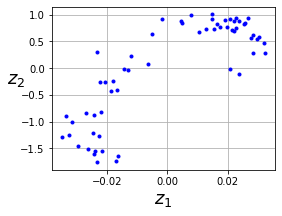

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.plot(coding[:,0], coding[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [6]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [7]:
stacked_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

stacked_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3365 - rounded_accuracy: 0.8885 - val_loss: 0.3181 - val_rounded_accuracy: 0.9085
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3045 - rounded_accuracy: 0.9162 - val_loss: 0.3058 - val_rounded_accuracy: 0.9104
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2983 - rounded_accuracy: 0.9217 - val_loss: 0.2976 - val_rounded_accuracy: 0.9252
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2945 - rounded_accuracy: 0.9251 - val_loss: 0.2952 - val_rounded_accuracy: 0.9274
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2918 - rounded_accuracy: 0.9275 - val_loss: 0.2919 - val_rounded_accuracy: 0.9287
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2899 - rounded_accuracy: 0.9291 - val_loss: 0.2904 - val_rounded_accuracy: 0.9298
Epoch 7/10
1719/1719 [============

In [8]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [9]:
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

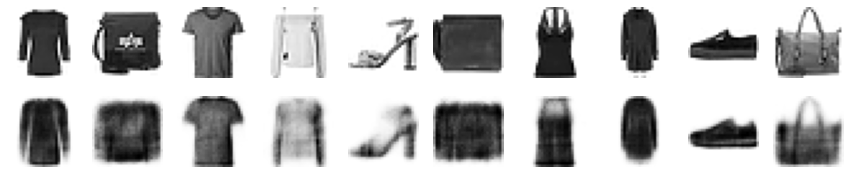

In [10]:
show_reconstructions(stacked_ae)

In [11]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

C:\Users\ozing\miniconda3\envs\handson-ml2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\ozing\miniconda3\envs\handson-ml2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


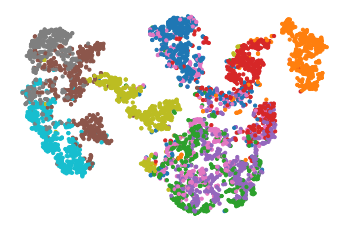

In [12]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

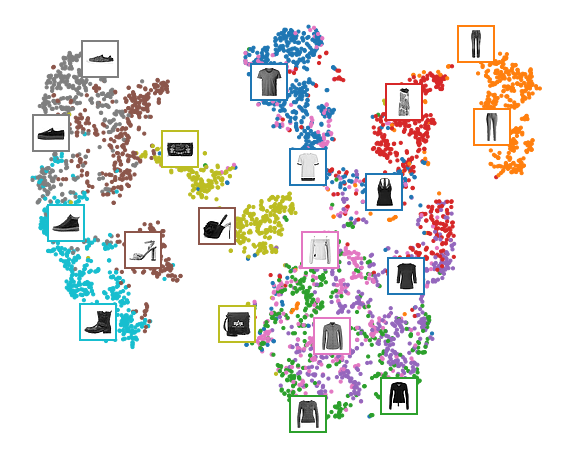

In [13]:
import matplotlib as mpl


plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [14]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_size):
        self.biases = self.add_weight(name="bias", initializer="zeros", shape=[self.dense.input_shape[-1]])
        super().build(batch_input_size)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [15]:
keras.backend.clear_session()

dense1 = keras.layers.Dense(100, activation="selu")
dense2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    dense1,
    dense2,
])

tied_decoder = keras.models.Sequential([ 
    DenseTranspose(dense2, activation="selu"),
    DenseTranspose(dense1, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

tied_coder = keras.models.Sequential([tied_encoder, tied_decoder])

tied_coder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

tied_coder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3294 - rounded_accuracy: 0.8928 - val_loss: 0.3042 - val_rounded_accuracy: 0.9192
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2989 - rounded_accuracy: 0.9207 - val_loss: 0.2962 - val_rounded_accuracy: 0.9233
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2922 - rounded_accuracy: 0.9268 - val_loss: 0.2918 - val_rounded_accuracy: 0.9264
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2887 - rounded_accuracy: 0.9301 - val_loss: 0.2897 - val_rounded_accuracy: 0.9287
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2866 - rounded_accuracy: 0.9320 - val_loss: 0.2881 - val_rounded_accuracy: 0.9338
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2851 - rounded_accuracy: 0.9334 - val_loss: 0.2861 - val_rounded_accuracy: 0.9344
Epoch 7/10
1719/1719 [============

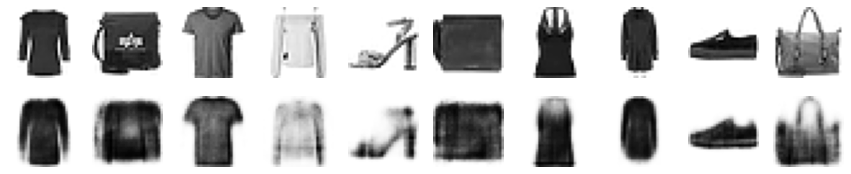

In [16]:
show_reconstructions(tied_coder)

In [17]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])

    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    
    autoencoder = keras.models.Sequential([encoder, decoder])
    
    autoencoder.compile(optimizer, loss, metrics=metrics)
    
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [18]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat, "binary_crossentropy", keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid", metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05), output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3450 - rounded_accuracy: 0.8873 - val_loss: 0.3120 - val_rounded_accuracy: 0.9152
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3036 - rounded_accuracy: 0.9207 - val_loss: 0.3004 - val_rounded_accuracy: 0.9249
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2951 - rounded_accuracy: 0.9285 - val_loss: 0.2937 - val_rounded_accuracy: 0.9307
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2896 - rounded_accuracy: 0.9337 - val_loss: 0.2893 - val_rounded_accuracy: 0.9355
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2858 - rounded_accuracy: 0.9373 - val_loss: 0.2862 - val_rounded_accuracy: 0.9389
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2832 - rounded_accuracy: 0.9399 - val_loss: 0.2838 - val_rounded_accuracy: 0.9407
Epoch 7/10
1719/1719 [==================

In [19]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1,
    enc2,
    dec2,
    dec1,
    keras.layers.Reshape([28, 28]),
])

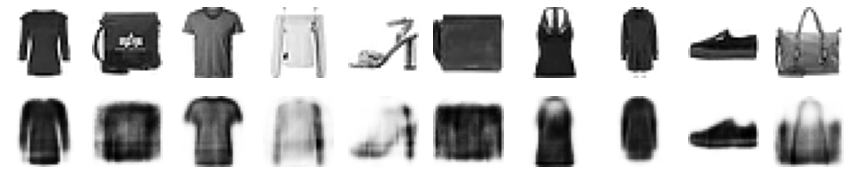

In [21]:
show_reconstructions(stacked_ae_1_by_1)

In [22]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])

stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2864 - rounded_accuracy: 0.9348 - val_loss: 0.2879 - val_rounded_accuracy: 0.9349
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2860 - rounded_accuracy: 0.9352 - val_loss: 0.2877 - val_rounded_accuracy: 0.9350
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2858 - rounded_accuracy: 0.9354 - val_loss: 0.2876 - val_rounded_accuracy: 0.9348
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2856 - rounded_accuracy: 0.9355 - val_loss: 0.2874 - val_rounded_accuracy: 0.9351
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2855 - rounded_accuracy: 0.9357 - val_loss: 0.2873 - val_rounded_accuracy: 0.9353
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2854 - rounded_accuracy: 0.9358 - val_loss: 0.2872 - val_rounded_accuracy: 0.9355
Epoch 7/10
1719/1719 [==================

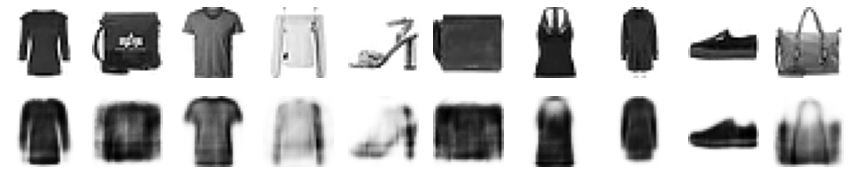

In [23]:
show_reconstructions(stacked_ae_1_by_1)